# Alveoli and acinar size
This document is used to plot the acinar volumes and stereological counts for the alveolar manuscript.

In [1]:
# Assess coding style, based on https://stackoverflow.com/a/47204361/323100

# %load_ext pycodestyle_magic
# and then put '%%pycodestyle' in the cells

# Or do it like so from the Terminal:
# jupyter nbconvert Load\ Datenblatt\ Stefan.ipynb --to script && flake8 *.py --ignore=W391

First, we set up the notebook.

In [2]:
#Load the data and set up notebook
import matplotlib.pyplot as plt
%matplotlib inline
import platform
import glob
import os
import pandas
import seaborn
import re
import timeit
import numpy

In [3]:
def get_git_hash():
    """
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    """
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git', '--git-dir', os.path.join(os.getcwd(), '.git'),
                        'rev-parse', '--short', '--verify', 'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [4]:
the_current_git_hash = get_git_hash()
print('We are working with version %s of the analyis notebook'
      % the_current_git_hash)

We are working with version 499a127 of the analyis notebook


In [5]:
# Display defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit
plt.rcParams['savefig.transparent'] = True  # Save figures with transparent background

In [6]:
# Make us an output folder (including the git hash, so we (potentially) have different versions of the images)
imgdir = os.path.join('img', the_current_git_hash)
os.makedirs(imgdir, exist_ok=True)

Now we load the 'Count' data from Eveline.

In [7]:
# # Different locations if running either on Linux or Windows
# if 'debian' in platform.dist():
#     drive = os.path.join(os.sep, 'home', 'habi', 'nas_gruppe_schittny')
# else:
#     drive = os.path.join('\\\\nas.ana.unibe.ch\\', 'gruppe_schittny', 'Data')
# # Load the data from this folder
# RootPath = os.path.join(drive, 'doc', 'David')
# print('We are loading all the data from %s' % RootPath)

In [8]:
# We copied everything from nas_schittny and the terastation to 'fast SSD'.
# Load the data from there
if 'debian' in platform.dist():
    drive = '/media/habi/Fast_SSD/'
else:
    drive = '\\\\anatera4\\'
# Load the data from this folder
RootPath = drive + os.path.join('Acini')
print('We are loading all the data from %s' % RootPath)

We are loading all the data from /media/habi/Fast_SSD/Acini


In [9]:
# Get a list of *all* excel files that Eveline exported from the STEPanizer
# Based on https://stackoverflow.com/a/14798263
StepanizerFiles_Eveline = sorted(glob.glob(os.path.join(RootPath, '**/*201[1234567]*.xls'), recursive=True))

In [10]:
print('Eveline counted the alveoli in %s acini' % len(StepanizerFiles_Eveline))

Eveline counted the alveoli in 287 acini


In [11]:
# # Grab relevant data from filenames
# for f in StepanizerFiles_Eveline:
#     print('Animal', os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:3])
#     print('Day', os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:2])
#     print('Acinus', os.path.basename(f).split('acinus')[1].split('_')[0])

In [12]:
# Generate dataframe to save Evelines assessment
Eveline = pandas.DataFrame({'Location': StepanizerFiles_Eveline})
Eveline['Filename'] = [os.path.basename(f) for f in StepanizerFiles_Eveline]
Eveline['Beamtime'] = [os.path.dirname(f).split('Acini')[1].split(os.sep)[1] for f in StepanizerFiles_Eveline]
Eveline['Sample'] = [os.path.basename(f).split('-acinus')[0][1:] for f in StepanizerFiles_Eveline]
Eveline['Animal'] = [os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:3] for f in StepanizerFiles_Eveline]
Eveline['Day'] = [int(os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:2]) for f in StepanizerFiles_Eveline]
Eveline['Acinus'] = [int(os.path.basename(f).split('acinus')[1].split('_')[0]) for f in StepanizerFiles_Eveline]
Eveline['Counts'] = [int(pandas.read_csv(f, nrows=13, delimiter='\t')['Total'][10]) for f in StepanizerFiles_Eveline]
# Since we seem to have different tab-count in the files, we just read one single cell, explicitly...
Eveline['Pixelsize'] = [float(pandas.read_csv(f, delimiter='\t', encoding='latin',
                                              skiprows=16, header=None, usecols=[0,1], nrows=1)[1][0])
                        for f in StepanizerFiles_Eveline]
# Count the images in their respective folders
Eveline['Number of images'] = [[int(os.path.basename(i).split('_')[-2]) for
                                  i in glob.glob(os.path.join(os.path.dirname(location),
                                                              '*.jpg'))] for
                                 location in Eveline.Location]
Eveline['Number of images'] = [max(li) for li in Eveline['Number of images']]

In [13]:
Eveline.groupby(by=['Day', 'Animal'])['Counts'].describe()

count        mean         std    min     25%    50%     75%    max
Day Animal                                                                    
4   04A      50.0   27.040000   23.687558    4.0   11.25   17.5   35.00  111.0
    04B      23.0   65.043478   43.849410   15.0   34.50   53.0   80.00  171.0
    04C      51.0   60.509804   45.424387   10.0   29.50   52.0   77.00  249.0
10  10A      27.0   77.851852   56.305283   18.0   28.50   69.0  122.00  245.0
    10B      14.0   84.571429   65.752115   23.0   37.50   52.0  135.25  199.0
    10C      17.0  108.764706  125.449955   15.0   46.00   73.0  105.00  505.0
21  21B      14.0  208.142857  197.709133   35.0   72.00  160.5  237.00  781.0
    21D      17.0  196.000000  128.564672   50.0   97.00  167.0  271.00  493.0
    21E      11.0  323.090909  145.936599  108.0  218.00  298.0  434.50  572.0
60  60B      24.0  350.875000  115.473058  161.0  253.25  364.0  424.50  648.0
    60C      20.0  103.800000   60.113577   30.0   68.00   86.0  127.00  270.0
    60D      10.0  363.700000   99.473112  222.0  299.25  368.5  390.00  591.0
    60E       9.0  395.777778  134.458895  136.0  368.00  370.0  472.00  602.0

In [14]:
# For D60, Eveline counted only half of the images, we thus double the 'counts'
Eveline.loc[Eveline.Day == 60, 'Counts'] = 2 * Eveline['Counts']
# The 'number of images' (read below) stays the same, since Eveline just skipped the images in STEPanizer!

In [15]:
Eveline.groupby(by=['Day', 'Animal'])['Counts'].describe()

count        mean         std    min     25%    50%     75%  \
Day Animal                                                                
4   04A      50.0   27.040000   23.687558    4.0   11.25   17.5   35.00   
    04B      23.0   65.043478   43.849410   15.0   34.50   53.0   80.00   
    04C      51.0   60.509804   45.424387   10.0   29.50   52.0   77.00   
10  10A      27.0   77.851852   56.305283   18.0   28.50   69.0  122.00   
    10B      14.0   84.571429   65.752115   23.0   37.50   52.0  135.25   
    10C      17.0  108.764706  125.449955   15.0   46.00   73.0  105.00   
21  21B      14.0  208.142857  197.709133   35.0   72.00  160.5  237.00   
    21D      17.0  196.000000  128.564672   50.0   97.00  167.0  271.00   
    21E      11.0  323.090909  145.936599  108.0  218.00  298.0  434.50   
60  60B      24.0  701.750000  230.946116  322.0  506.50  728.0  849.00   
    60C      20.0  207.600000  120.227153   60.0  136.00  172.0  254.00   
    60D      10.0  727.400000  198.946224  444.0  598.50  737.0  780.00   
    60E       9.0  791.555556  268.917790  272.0  736.00  740.0  944.00   

               max  
Day Animal          
4   04A      111.0  
    04B      171.0  
    04C      249.0  
10  10A      245.0  
    10B      199.0  
    10C      505.0  
21  21B      781.0  
    21D      493.0  
    21E      572.0  
60  60B     1296.0  
    60C      540.0  
    60D     1182.0  
    60E     1204.0

# Laut Telefon mit Stefan (8.1.2018)
- Eveline zählte beide Richtungen -> Disector-Volumen verdoppeln (7.4 -> 14.8)
- Dies * Counting area -> Counting Volume
- Dies * Anzahl Bilder -> Total counting volume
- Counts pro totalem Volumen -> Alveolar fraction
- Alveolar fraction * Volumen aus MeVisLab -> Alveolen pro Acinus.

In [16]:
# Copied verbatim from ReadVolumeSurfaceAndAlveaolarNumber.py
DisectorThickness = 5  # slices
TOMCATPixelSize = 1.48   # um
ShrinkageFactor = 0.61   # Volume-Shrinkage-Factor = 61% with STD=5, calculated by Sébastien: Volume TOMCAT / Waterdisplacement

In [17]:
# Get a list of *all* the excel files I counted are from the STEPanizer
# Differing to the ones from Eveline, we only have '2018' in the file name...
StepanizerFiles_David = sorted(glob.glob(os.path.join(RootPath, '**/*2018*.xls'), recursive=True))

In [18]:
print('David assessed the disector volume in %s acini' % len(StepanizerFiles_David))

David assessed the disector volume in 143 acini


In [19]:
David = pandas.DataFrame({'Location': StepanizerFiles_David})
David['Filename'] = [os.path.basename(f) for f in StepanizerFiles_David]
David['Animal'] = [os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:3] for f in StepanizerFiles_David]
David['Day'] = [int(os.path.basename(f).split('_R108C')[1].split('mrg-')[0][:2]) for f in StepanizerFiles_David]
David['Beamtime'] = [os.path.dirname(f).split('Acini')[1].split(os.sep)[1] for f in StepanizerFiles_David]
David['Sample'] = [os.path.basename(f).split('-acinus')[0][1:] for f in StepanizerFiles_David]
David['Acinus'] = [int(os.path.basename(f).split('acinus')[1].split('_')[0]) for f in StepanizerFiles_David]
David['Counts'] = [int(pandas.read_csv(f, nrows=13,
                                       delimiter='\t')['Total'][10]) for f in StepanizerFiles_David]
David['Pixelsize'] = [float(pandas.read_csv(f, skiprows=16, nrows=1, delimiter='\t', encoding='latin',
                                            header=None, usecols=[1])[1]) for f in StepanizerFiles_David]
David['Area per point'] = [float(pandas.read_csv(f, delimiter='\t', encoding='latin',
                                                 skiprows=28, header=None, usecols=[0,1],
                                                 nrows=1)[1][0]) for f in StepanizerFiles_David]
David['Volume per point'] = [DisectorThickness * TOMCATPixelSize * 2 * ap
                                      for ap in David['Area per point']]
# Read the number of images from the xls-file instead of counting from disk
# MIght be good for error-checking...
David['Number of images'] = [int(pandas.read_csv(f, delimiter='\t', encoding='latin',
                                                 skiprows=12, header=None, usecols=[0,1, 2, 3],
                                                 nrows=1)[2][0][2:])  # Stefan writes '->NumImg' into the cell, so we read only everything from string position 3 on...
                             for f in StepanizerFiles_David]
David['Acinusvolume'] = [vpp * cts for vpp, cts in zip(David['Volume per point'],
                                                       David['Counts'])]

In [20]:
# Merge 'Eveline' and 'David' to evaluate the data
# See the 'DisectorVolumes' notebook for which acini remain to count!
# Based on https://stackoverflow.com/a/33350050/323100
Done = pandas.merge(Eveline, David,
                    on=['Animal', 'Acinus', 'Day', 'Beamtime', 'Sample'],
                    how='inner', suffixes=['_Eveline', '_David'],
                    indicator=True)
print('We have the data of %s acini...' % len(Done))
print('We thus still need to count approximately %s acini...' % (len(Eveline) - len(David)))

We have the data of 143 acini...
We thus still need to count approximately 144 acini...


In [21]:
Done.head()

,Location_Eveline,Filename_Eveline,Beamtime,Sample,Animal,Day,Acinus,Counts_Eveline,Pixelsize_Eveline,Number of images_Eveline,Location_David,Filename_David,Counts_David,Pixelsize_David,Area per point,Volume per point,Number of images_David,Acinusvolume,_merge
0,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus03_2012-06-11_11-49_resul...,2009f,R108C60Dt-mrg,60D,60,3,1182,2.44,93,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus03_2018-01-26_12-57_resul...,526,2.00,141125.44,2088656.512,93,1.098633e+09,both
1,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus15_2012-10-22_09-46_resul...,2009f,R108C60Dt-mrg,60D,60,15,790,1.67,96,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus15_2018-01-23_18-03_resul...,707,1.37,66206.34,979853.832,96,6.927567e+08,both
2,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus19_2012-09-03_16-48_resul...,2009f,R108C60Dt-mrg,60D,60,19,444,1.20,75,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus19_2018-01-22_12-41_resul...,655,1.03,37497.46,554962.408,75,3.635004e+08,both
3,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus23_2012-09-04_16-54_resul...,2009f,R108C60Dt-mrg,60D,60,23,736,1.96,138,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Dt...,_R108C60Dt-mrg-acinus23_2018-01-16_15-31_resul...,759,1.69,101354.10,1500040.680,138,1.138531e+09,both
4,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Et...,_R108C60Et-mrg-acinus08_2012-09-27_13-47_resul...,2009f,R108C60Et-mrg,60E,60,8,770,2.17,141,/media/habi/Fast_SSD/Acini/2009f/mrg/R108C60Et...,_R108C60Et-mrg-acinus08_2018-02-02_15-51_resul...,1086,1.82,116632.60,1726162.480,141,1.874612e+09,both


In [22]:
# Set ourselves a palette, based on the individual unique sample names
# The dictionary palette setting is based on the comments in https://stackoverflow.com/q/36554075/323100
ourcolors=seaborn.color_palette('husl', len(pandas.unique(Eveline.Animal)))
ourpalette = {animal:ourcolors[c] for c, animal in enumerate(pandas.unique(Eveline.Animal))}

In [23]:
# Set indivdual measurement color (in dataframe)
Eveline['Color'] = [None] * len(Eveline)
for c,animal in enumerate(Eveline.Animal):
    for d,i in enumerate(pandas.unique(Eveline.Animal)):
        if animal == i:
            Eveline.set_value(c, 'Color', ourcolors[d])

Load the volume data directly from `anatera4`, where I originally exported the DICOM files from MeVisLab (and where the data still is).
After doing that, we save it to a dataframe on disk, since looking for all the DICOM files takes nearly an hour...

In [24]:
# Different locations if running either on Linux or Windows
if 'debian' in platform.dist():
    drive = '/run/user/1000/gvfs/smb-share:server=anatera4,share='
else:
    drive = '\\\\anatera4\\'
# Load the data from this folder
terastation = drive + os.path.join('share', 'SLS')
print('We are loading all the data from %s' % terastation)

We are loading all the data from /run/user/1000/gvfs/smb-share:server=anatera4,share=share/SLS


In [25]:
# Filename to save the data, with included git hash for versioning purposes...
OutputName_Volumes = 'VolumesFromDisk_' + get_git_hash() + '.pkl'

In [26]:
# Use the *newest* VolumesFromDisk file, even if it's from another git hash
OutputName_Volumes = max(glob.iglob('VolumesFromDisk*.pkl'), key=os.path.getctime)

In [27]:
if get_git_hash() != os.path.splitext(OutputName_Volumes.split('_')[1])[0]:
    print('Hash is not the same as OutputName_Volumes!')
else:
    print('Good to go!')

Good to go!


In [28]:
# Get a list of *all* DICOM files that I exported aeons ago
# Based on https://stackoverflow.com/a/14798263
# This takes between 30 and 60 minutes!!!
# We thus only do it if we cannot read the dataframe with all the data that we save later on...
if os.path.exists(OutputName_Volumes):
    print('We load the data from %s' % OutputName_Volumes)
else:
    print('We scan %s for "R108*.dcm" files' % terastation)
    tic = timeit.default_timer()
    AcinarVolumeFiles = sorted(glob.glob(os.path.join(terastation, '**/R108*.dcm'), recursive=True))
    toc = timeit.default_timer()
    print('We found %s DICOM files in %s minutes' % (len(AcinarVolumeFiles),
                                                     round(float((toc - tic) / 60.), 1)))

We load the data from VolumesFromDisk_499a127.pkl


In [29]:
# Collect the data into a dataframe
if os.path.exists(OutputName_Volumes):
    # We already did it once, so just load it...
    VolumesFromDisk = pandas.read_pickle(OutputName_Volumes)
else:
    # Save the file locations into an empty dataframe
    VolumesFromDisk = pandas.DataFrame({'Location_Volume': AcinarVolumeFiles})

In [30]:
# # Grab relevant data from filenames (used to get the string matching right...)
# for f in AcinarVolumeFiles:
#     print(os.path.basename(f))
#     print('Animal', os.path.basename(f).split('R108C')[1].split('mrg.')[0][:-2])
#     print('Day', os.path.basename(f).split('R108C')[1].split('mrg')[0][:2])
#     print('Acinus', os.path.basename(f).split('.acinus')[1].split('.volume')[0])
#     print('Volume', os.path.basename(f).split('.volume')[1].split('.pixelsize')[0])
#     print('Scantime', os.path.dirname(f).split('SLS')[1].split(os.sep)[1])
#     print(80*'-')

In [31]:
# # Some names (see output of this cell) derive from the R108C$Day$$Animal$ scheme.
# # We catch them with the intricate .split() in the cells below...
# for i in VolumesFromDisk.File:
#     if len(i.split('mrg')[0][len('R108C'):-2]) >3:
#         tmp.append(i.split('mrg')[0][len('R108C'):-2])
# for i in pandas.unique(tmp):
#     print(i)

In [32]:
if not os.path.exists(OutputName_Volumes):
    VolumesFromDisk['Filename_Volume'] = [os.path.basename(f) for f in AcinarVolumeFiles]
    VolumesFromDisk['Animal'] = [os.path.basename(f).split('mrg')[0][len('R108C'):len('R108C')+3]
                                 for f in AcinarVolumeFiles]
    VolumesFromDisk['Beamtime'] = [os.path.dirname(f).split('SLS')[1].split(os.sep)[1]
                                   for f in AcinarVolumeFiles]
    VolumesFromDisk['Day'] = [int(os.path.basename(f).split('mrg')[0][len('R108C'):len('R108C')+2])
                              for f in AcinarVolumeFiles]
    VolumesFromDisk['Acinus'] = [int(os.path.basename(f).split('.acinus')[1].split('.volume')[0])
                                 for f in AcinarVolumeFiles]
    # According to the MeVisLab files, the volume is saved to the file name in 'ul'.
    # To get cm³ we divide by 1000
    VolumesFromDisk['Volume'] = [float(os.path.basename(f).split('.volume')[1].split('.pixelsize')[0]) / 1000
                                 for f in AcinarVolumeFiles]  # cm³

In [33]:
VolumesFromDisk['Filename_Volume'][0]

'R108C21A2t-mrg.2240.2940.1024.gvr.acinus1.volume0.018193666.pixelsize0.00148000009357929.dcm'

In [34]:
# Save the data and give some feedback.
if not os.path.exists(OutputName_Volumes):
    VolumesFromDisk.to_pickle(OutputName_Volumes)
print('We have %s acini where we have volumes' % len(VolumesFromDisk))

We have 811 acini where we have volumes


In [35]:
VolumesFromDisk.groupby(by=['Day', 'Animal'])['Volume'].describe()

count      mean       std           min       25%       50%  \
Day Animal                                                                
4   04A      51.0  0.000006  0.000005  9.182831e-07  0.000002  0.000004   
    04B      23.0  0.000035  0.000035  6.500183e-06  0.000014  0.000023   
    04C      51.0  0.000029  0.000025  4.332695e-06  0.000013  0.000024   
    04D      44.0  0.000024  0.000024  3.993681e-06  0.000009  0.000017   
    04E      43.0  0.000011  0.000009  1.216217e-06  0.000004  0.000009   
10  10A      32.0  0.000018  0.000012  2.227656e-06  0.000007  0.000015   
    10B      27.0  0.000017  0.000014  3.091166e-06  0.000006  0.000013   
    10C      69.0  0.000029  0.000034  1.266426e-06  0.000008  0.000016   
    10D      34.0  0.000020  0.000012  5.223176e-06  0.000012  0.000016   
    10E      33.0  0.000011  0.000008  2.034290e-06  0.000005  0.000007   
21  21A      24.0  0.000043  0.000037  3.040957e-06  0.000018  0.000030   
    21B      42.0  0.000047  0.000038  6.526948e-06  0.000019  0.000040   
    21D      94.0  0.000069  0.000083  1.511868e-06  0.000021  0.000034   
    21E      51.0  0.000079  0.000068  7.257673e-06  0.000035  0.000062   
36  36A      30.0  0.000099  0.000098  1.103745e-05  0.000037  0.000081   
    36C      54.0  0.000106  0.000075  1.325660e-05  0.000052  0.000082   
    36D      25.0  0.000115  0.000081  2.456376e-05  0.000066  0.000094   
60  60B      24.0  0.000319  0.000133  1.339540e-04  0.000225  0.000306   
    60C      41.0  0.000039  0.000029  5.616134e-06  0.000018  0.000030   
    60D      10.0  0.000434  0.000128  2.322982e-04  0.000322  0.000441   
    60E       9.0  0.000460  0.000226  1.248685e-04  0.000337  0.000512   

                 75%       max  
Day Animal                      
4   04A     0.000008  0.000022  
    04B     0.000034  0.000121  
    04C     0.000038  0.000135  
    04D     0.000027  0.000108  
    04E     0.000013  0.000046  
10  10A     0.000026  0.000049  
    10B     0.000020  0.000052  
    10C     0.000036  0.000172  
    10D     0.000026  0.000053  
    10E     0.000017  0.000030  
21  21A     0.000065  0.000144  
    21B     0.000057  0.000216  
    21D     0.000083  0.000393  
    21E     0.000104  0.000347  
36  36A     0.000111  0.000522  
    36C     0.000134  0.000395  
    36D     0.000164  0.000381  
60  60B     0.000427  0.000667  
    60C     0.000046  0.000131  
    60D     0.000545  0.000590  
    60E     0.000671  0.000752

In [37]:
cts = numpy.mean(Eveline.loc[Eveline.Day == 21]['Counts'])
print(cts)

233.333333333


In [38]:
vol = numpy.mean(VolumesFromDisk.loc[VolumesFromDisk.Day == 21]['Volume']) * 1e12
print(vol)

63819193.5161


In [39]:
vol / cts

273510.82935477322

In [40]:
numpy.cbrt((3*vol)/(4*numpy.pi))

247.90630223175737

In [41]:
# List all the beamtime times (dates where we've been at TOMCAT)
print(VolumesFromDisk['Beamtime'].unique())

['2009f' '2010a' '2010b' '2010c_tape']


In [42]:
# Update palette, since we might have more animals than what we had above in cell 19
ourcolors = seaborn.color_palette('husl', len(pandas.unique(VolumesFromDisk.Animal)))
ourpalette = {animal: ourcolors[c] for c, animal in enumerate(sorted(pandas.unique(VolumesFromDisk.Animal)))}

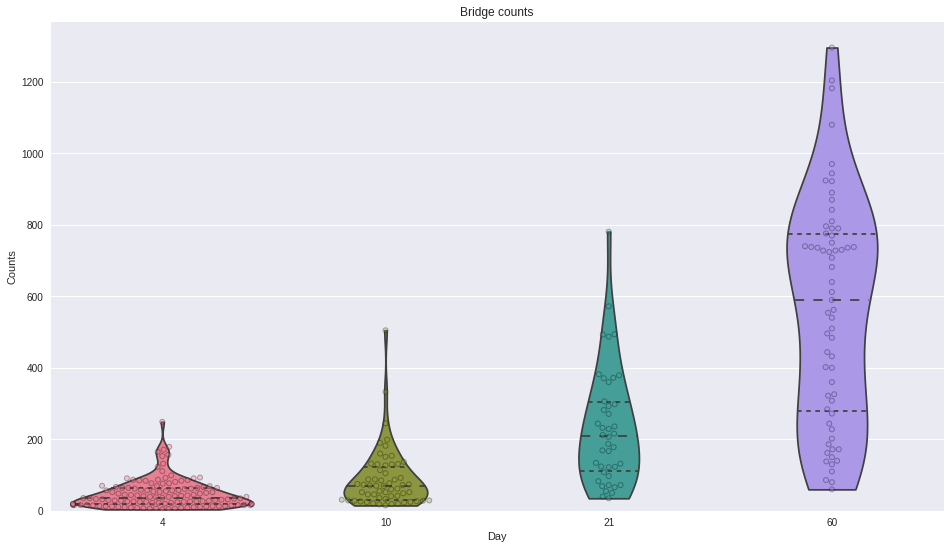

In [43]:
seaborn.violinplot(data=Eveline, x='Day', y='Counts', cut=0, scale='count',
                   palette=seaborn.color_palette('husl', len(pandas.unique(Eveline.Day))),
                   inner='quartiles')
seaborn.swarmplot(data=Eveline, x='Day', y='Counts', linewidth=1,
                  palette=seaborn.color_palette('husl', len(pandas.unique(Eveline.Day))),
                  edgecolor='k', alpha=0.309)
plt.title('Bridge counts')
plt.ylim(ymin=0)
plt.savefig(os.path.join(imgdir, 'counts_global.png'), bbox_inches='tight')
plt.show()

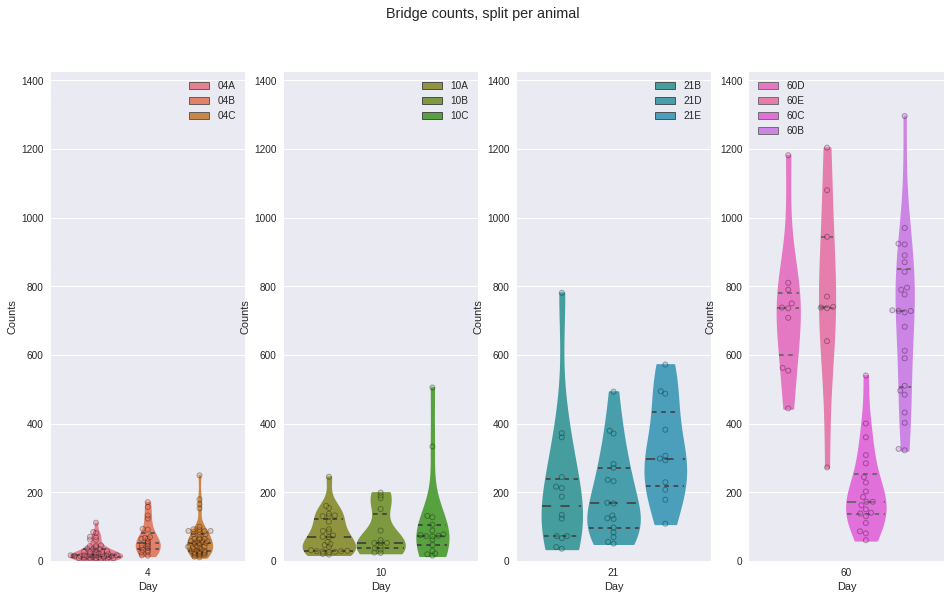

In [44]:
for c, d in enumerate(sorted(pandas.unique(Eveline.Day))):
    plt.subplot(1, len(pandas.unique(Eveline.Day)), c + 1)
    bxplt = seaborn.violinplot(data=Eveline.loc[Eveline.Day == d], x='Day', y='Counts',
                               hue='Animal', palette=ourpalette, cut=0, inner='quartiles')
    swrmplt = seaborn.swarmplot(data=Eveline.loc[Eveline.Day == d], x='Day', y='Counts', hue='Animal',
                                split=True, linewidth=1, palette=ourpalette, edgecolor='k', alpha=0.309)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0, 1.1*Eveline.Counts.max()])
    bxplt.legend(handles[:len(handles)//2], labels[:len(labels)//2])
plt.suptitle('Bridge counts, split per animal')
plt.savefig(os.path.join(imgdir, 'counts_day.png'), bbox_inches='tight')
plt.show()

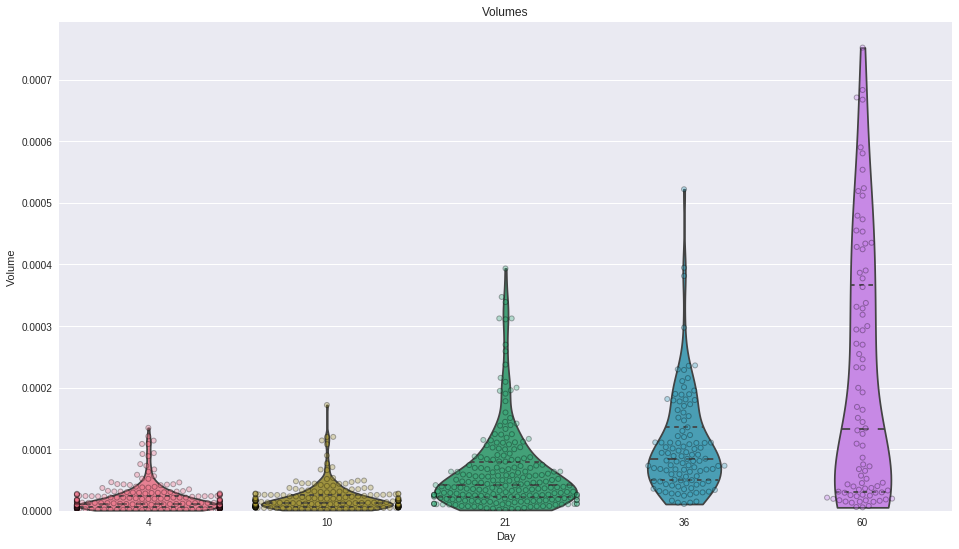

In [45]:
seaborn.violinplot(data=VolumesFromDisk, x='Day', y='Volume', cut=0, scale='count',
                   palette=seaborn.color_palette('husl', len(pandas.unique(VolumesFromDisk.Day))),
                   inner='quartiles')
seaborn.swarmplot(data=VolumesFromDisk, x='Day', y='Volume', linewidth=1,
                  palette=seaborn.color_palette('husl', len(pandas.unique(VolumesFromDisk.Day))),
                  edgecolor='k', alpha=0.309)
plt.title('Volumes')
plt.ylim(ymin=0)
plt.savefig(os.path.join(imgdir, 'volumes_global.png'), bbox_inches='tight')
plt.show()

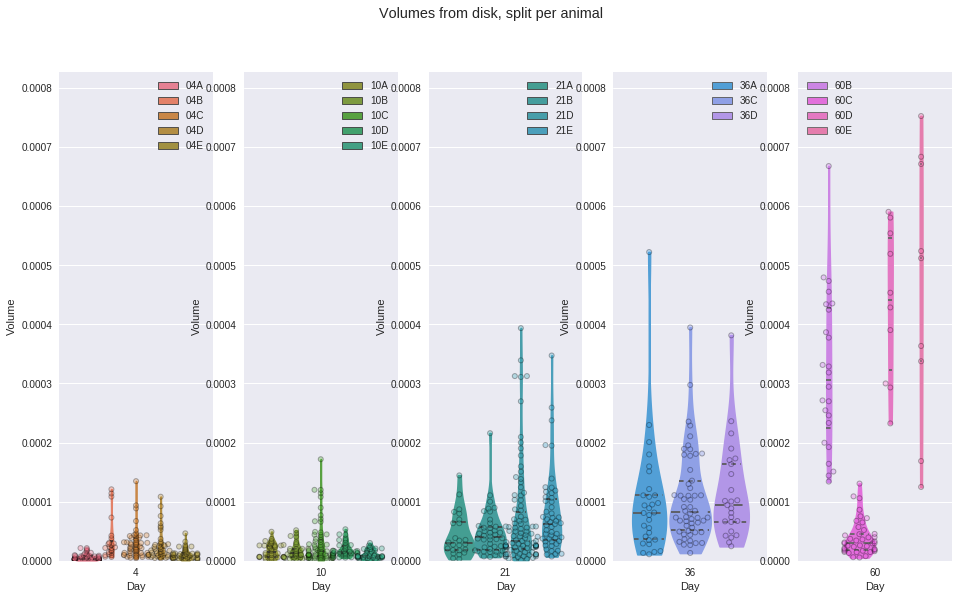

In [46]:
for c, d in enumerate(sorted(pandas.unique(VolumesFromDisk.Day))):
    plt.subplot(1, len(pandas.unique(VolumesFromDisk.Day)), c + 1)
    bxplt = seaborn.violinplot(data=VolumesFromDisk.loc[VolumesFromDisk.Day == d], x='Day', y='Volume',
                               hue='Animal',
                               # Because the animals are preferentially sorted on the beamtime name, we have
                               # to jump through the hoop below and sort the hues on the 'Animal' in addition
                               # to what we did for Evelines counts where all the data is in *one* folder
                               # Just comment the next line to see the difference (a correct plot, but ugly sort :)
                               hue_order=sorted(pandas.unique(VolumesFromDisk.loc[VolumesFromDisk.Day == d]['Animal'])),
                               palette=ourpalette, cut=0, inner='quartiles')
    swrmplt = seaborn.swarmplot(data=VolumesFromDisk.loc[VolumesFromDisk.Day == d], x='Day', y='Volume',
                                hue='Animal',
                                hue_order=sorted(pandas.unique(VolumesFromDisk.loc[VolumesFromDisk.Day == d]['Animal'])),
                                split=True, linewidth=1, palette=ourpalette, edgecolor='k', alpha=0.309)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0, 1.1*VolumesFromDisk.Volume.max()])
    bxplt.legend(handles[:len(handles)//2], labels[:len(labels)//2])
plt.suptitle('Volumes from disk, split per animal')
plt.savefig(os.path.join(imgdir, 'volumes_day.png'), bbox_inches='tight')
plt.show()

Now we 'just' have to concatenate the two dataframes :)

In [47]:
# Filename to save the data, with included git hash for versioning purposes...
OutputName_Merged = 'Merged_' + get_git_hash() + '.pkl'

In [48]:
# Merge the dataframes: http://pandas.pydata.org/pandas-docs/stable/merging.html
# This seems to discard all entries that are *not* found in both df's
if os.path.exists(OutputName_Merged):
    # We already did it once, so just load it...
    Merged = pandas.read_pickle(OutputName_Merged)
else:    
    Merged = pandas.merge(Counts, VolumesFromDisk)#,
    #                       on=['Animal', 'Acinus', 'Day'],
    #                       how='inner',
    #                       suffixes=('_from_counts', '_from_volume'))

In [49]:
# Doublecheck merged file names (for 10 random items from dataframe)
# To make the checking a bit easier, we split the strings and only show the interesting bit
for i in range(5):
    number = numpy.random.randint(len(Merged))
    print('Beamtime:', Merged.iloc[number]['Beamtime'])
    print('From Volume: Animal', Merged.iloc[number].Filename_Volume.split('mrg.')[0],
          '| Acinus',  Merged.iloc[number].Filename_Volume.split('acinus')[1].split('.volume')[0],
          '| Volume', Merged.iloc[number]['Volume'])
    print('From Counts: Animal', Merged.iloc[number].Filename_Counts.split('mrg-')[0][1:],
          '| Acinus',  Merged.iloc[number].Filename_Counts.split('acinus')[1].split('_201')[0],
          '| Counts', Merged.iloc[number]['Counts'])
    print('Alveolar fraction:', round(Merged.iloc[number]['Alveolar fraction'], 1) )
    print(40 * '-')

Beamtime: 2009f
From Volume: Animal R108C60Et- | Acinus 8 | Volume 0.00075202513
From Counts: Animal R108C60Et- | Acinus 08 | Counts 770
Alveolar fraction: 98348.7
----------------------------------------
Beamtime: 2010a
From Volume: Animal R108C04Bt- | Acinus 41 | Volume 1.3034392e-05
From Counts: Animal R108C04Bt- | Acinus 41 | Counts 25
Alveolar fraction: 228799.6
----------------------------------------
Beamtime: 2009f
From Volume: Animal R108C60Dt- | Acinus 18 | Volume 0.0004532719
From Counts: Animal R108C60Dt- | Acinus 18 | Counts 708
Alveolar fraction: 131137.4
----------------------------------------
Beamtime: 2009f
From Volume: Animal R108C60Dt- | Acinus 19 | Volume 0.00023229824
From Counts: Animal R108C60Dt- | Acinus 19 | Counts 444
Alveolar fraction: 347107.5
----------------------------------------
Beamtime: 2010c_tape
From Volume: Animal R108C60B_B1_ | Acinus 27 | Volume 0.00027121842
From Counts: Animal R108C60B_B1_ | Acinus 27 | Counts 724
Alveolar fraction: 417605.2
-

In [50]:
if not os.path.exists(OutputName_Merged):
    Merged['CpV'] = Merged['Counts'] / Merged['Volume']

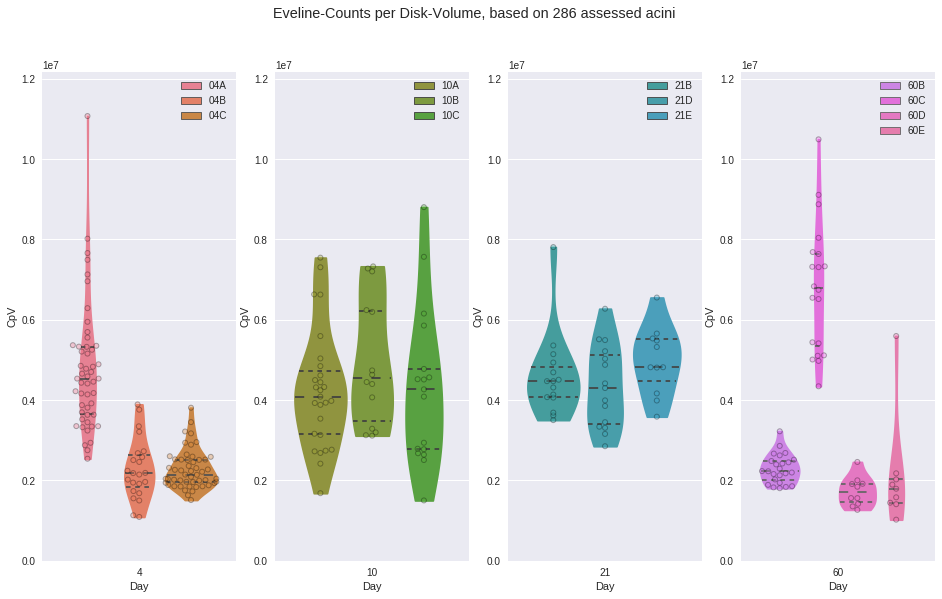

In [51]:
for c, d in enumerate(sorted(pandas.unique(Merged.Day))):
    plt.subplot(1, len(pandas.unique(Merged.Day)), c + 1)
    bxplt = seaborn.violinplot(data=Merged.loc[Merged.Day == d], x='Day', y='CpV',
                               hue='Animal',
                               hue_order=sorted(pandas.unique(Merged.loc[Merged.Day == d]['Animal'])),
                                   palette=ourpalette, cut=0, inner='quartiles')
    swrmplt = seaborn.swarmplot(data=Merged.loc[Merged.Day == d], x='Day', y='CpV',
                                hue='Animal',
                                hue_order=sorted(pandas.unique(Merged.loc[Merged.Day == d]['Animal'])),
                                split=True, linewidth=1, palette=ourpalette, edgecolor='k', alpha=0.309)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0, 1.1 * Merged.CpV.max()])
    bxplt.legend(handles[:len(handles)//2], labels[:len(labels)//2])
plt.suptitle('Eveline-Counts per Disk-Volume, based on %s assessed acini' % len(Merged))
plt.savefig(os.path.join(imgdir, 'counts_per_volume_day_eveline-disk.png'), bbox_inches='tight')
plt.show()

In [52]:
Done['Counts per Volume'] = [cts / vol for cts, vol in zip(Done['Counts_Eveline'], Done['Acinusvolume'])]

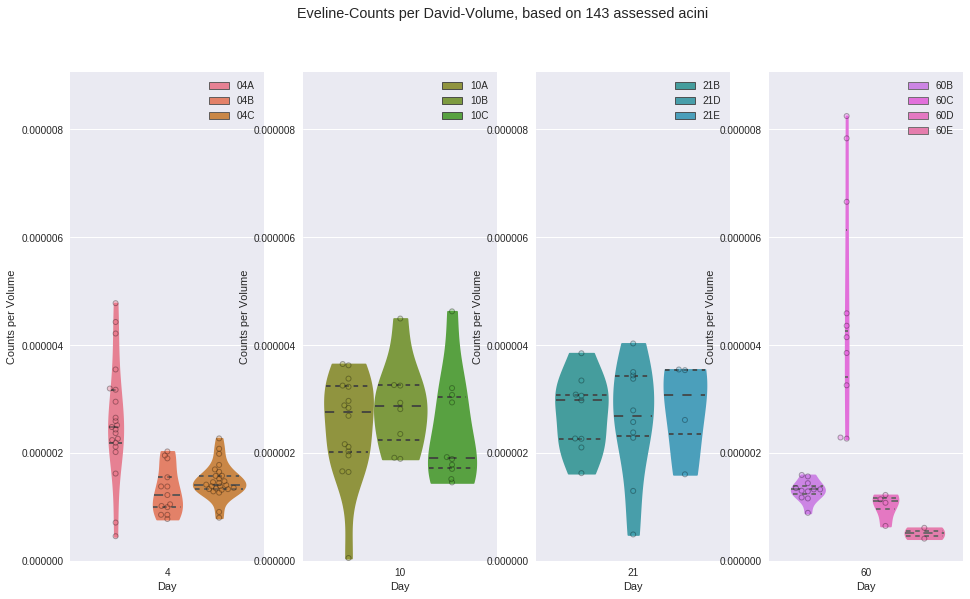

In [53]:
for c, d in enumerate(sorted(pandas.unique(Done.Day))):
    plt.subplot(1, len(pandas.unique(Done.Day)), c + 1)
    bxplt = seaborn.violinplot(data=Done.loc[Done.Day == d], x='Day', y='Counts per Volume',
                               hue='Animal', palette=ourpalette, cut=0, inner='quartiles',
                               hue_order=sorted(pandas.unique(Done.loc[Done.Day == d]['Animal'])))
    swrmplt = seaborn.swarmplot(data=Done.loc[Done.Day == d], x='Day', y='Counts per Volume', hue='Animal',
                                split=True, linewidth=1, palette=ourpalette, edgecolor='k', alpha=0.309,
                                hue_order=sorted(pandas.unique(Done.loc[Done.Day == d]['Animal'])))
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0, 1.1 * Done['Counts per Volume'].max()])
    bxplt.legend(handles[:len(handles)//2], labels[:len(labels)//2], loc='upper right')    
plt.suptitle('Eveline-Counts per David-Volume, based on %s assessed acini' % len(Done))
plt.savefig(os.path.join(imgdir, 'counts_per_volume_day_eveline-david.png'), bbox_inches='tight')
plt.show()

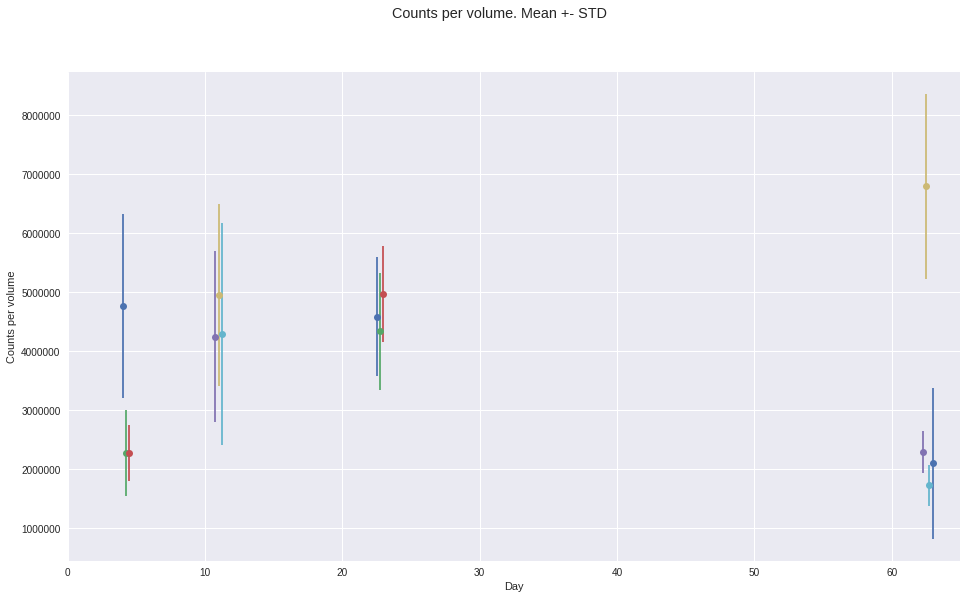

In [54]:
# Plot mean +- STD
for c, d in enumerate(pandas.unique(Merged.Animal)):
    #     print(d)
    #     print(numpy.mean(Merged.loc[Merged.Animal == d]['Day']))
    #     print(numpy.mean(Merged.loc[Merged.Animal == d]['CpV']))
    #     print(numpy.std(Merged.loc[Merged.Animal == d]['CpV']))
    #     plt.scatter(numpy.mean(Merged.loc[Merged.Animal == d]['Day']), numpy.mean(Merged.loc[Merged.Animal == d]['CpV']))
    plt.errorbar(numpy.mean(Merged.loc[Merged.Animal == d]['Day']) + 0.25 * c % 5,
                 numpy.mean(Merged.loc[Merged.Animal == d]['CpV']),
                 yerr=numpy.std(Merged.loc[Merged.Animal == d]['CpV']),
                 fmt='o')
    plt.xlabel('Day')
    plt.ylabel('Counts per volume')
    plt.xlim([0, 65])
plt.suptitle('Counts per volume. Mean +- STD')   
plt.savefig(os.path.join(imgdir, 'mean_counts.png'), bbox_inches='tight')
plt.show()

In [55]:
if not os.path.exists(OutputName_Merged):
    Merged['Alveoli'] = Merged['Alveolar fraction'] * Merged['Volume']

In [56]:
# Get the mean number of alveoli per acinus
print('Based on Tschanz2014 and Barre2014...')
# Number of alveoli (19.297e6) from Tschanz2014, Table 1, p. 91)
# Number of acini (5943) from Barre2014, Table 2, p. 7 
n_alv = 19.279 * 1e6
n_acini = 5943
alv_pro_acinus = n_alv / n_acini
print('We have approximately %0.0f alveoli per acinus.' % alv_pro_acinus)
lung_volume = 10.21  # cm³
acinar_volume = lung_volume / n_acini
print('One acinus in D60 lungs thus has a volume of approximately %0.2g um^3.' % acinar_volume)

Based on Tschanz2014 and Barre2014...
We have approximately 3244 alveoli per acinus.
One acinus in D60 lungs thus has a volume of approximately 0.0017 um^3.


In [57]:
# Get the mean volume for our volumes
print('One acinus in *our* extracted acini of the D60 lungs has a volume of '
      'approximately %0.2g um^3.' % numpy.average(Merged.loc[Merged.Day == 60]['Volume']))

One acinus in *our* extracted acini of the D60 lungs has a volume of approximately 0.00027 um^3.


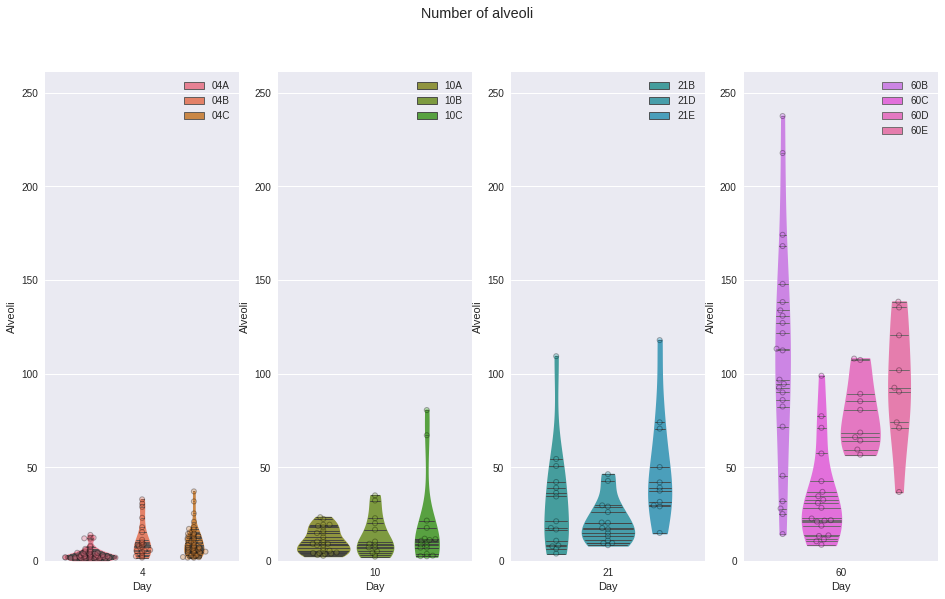

In [58]:
for c, d in enumerate(sorted(pandas.unique(Merged.Day))):
    plt.subplot(1, len(pandas.unique(Merged.Day)), c + 1)
    bxplt = seaborn.violinplot(data=Merged.loc[Merged.Day == d], x='Day', y='Alveoli',
                               hue='Animal',
                               hue_order=sorted(pandas.unique(Merged.loc[Merged.Day == d]['Animal'])),
                               palette=ourpalette, cut=0, inner='stick')
    swrmplt = seaborn.swarmplot(data=Merged.loc[Merged.Day == d], x='Day', y='Alveoli',
                                hue='Animal',
                                hue_order=sorted(pandas.unique(Merged.loc[Merged.Day == d]['Animal'])),
                                split=True, linewidth=1, palette=ourpalette, edgecolor='k', alpha=0.309)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.ylim([0, 1.1 * Merged.Alveoli.max()])
    bxplt.legend(handles[:len(handles)//2], labels[:len(labels)//2])
plt.suptitle('Number of alveoli')
plt.savefig(os.path.join(imgdir, 'number_of_alveoli.png'), bbox_inches='tight')
plt.show()

After discussion with Stefan, we need to actually properly assess the disector volume.
The way we did it now is having the 'disector volume' equal to the 'counting frame' volume.
But since our acini are (significantly) smaller than the counting frame, we get the wrong data, e.g. overestimate it.

To properly prepare this, we thus get *two* random acini from each day and use these for setting up a proper stereological analysis.

In [59]:
for d in [4,10,21,60]:
    print('For day %2s we have %3s acini' % (d, len(Merged[Merged.Day==d])))

For day  4 we have 124 acini
For day 10 we have  58 acini
For day 21 we have  41 acini
For day 60 we have  63 acini


In [60]:
# numpy.random.seed(1796)
for d in [4,10,21,60]:
    for k in range(2):
        item = numpy.random.randint(len(Merged[Merged.Day==d])) 
        print('For day %2s (Item %s) we look at item %3s' % (d, k + 1, item))
        print('    - This is animal %s, acinus %s' % (Merged[Merged.Day==d].iloc[item].Animal,
                                                 Merged[Merged.Day==d].iloc[item].Acinus))
        print('    - To assess the disector volume, open the %s images '
              'from \n        %s\n      in the STEPanizer' % (Merged[Merged.Day==d].iloc[item]['Number of images'],
                                               os.path.join(
                                                   os.path.dirname(Merged[Merged.Day==d].iloc[item].Location_Volume[len(terastation)+1:]),
                                                   'acinus%2s' % str(Merged[Merged.Day==d].iloc[item].Acinus).zfill(2),
                                                   'voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices')))
    print()

For day  4 (Item 1) we look at item 122
    - This is animal 04C, acinus 61
    - To assess the disector volume, open the 40 images from 
        2010a/mrg/R108C04Ct-mrg/acinus61/voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices
      in the STEPanizer
For day  4 (Item 2) we look at item  20
    - This is animal 04A, acinus 48
    - To assess the disector volume, open the 32 images from 
        2010a/mrg/R108C04At-mrg/acinus48/voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices
      in the STEPanizer

For day 10 (Item 1) we look at item  42
    - This is animal 10C, acinus 4
    - To assess the disector volume, open the 43 images from 
        2010c_tape/R108C10C_B1_mrg_10c/acinus04/voxelsize1.48-every10slice-DisectorThickness-7.40um-or5slices
      in the STEPanizer
For day 10 (Item 2) we look at item  11
    - This is animal 10A, acinus 22
    - To assess the disector volume, open the 35 images from 
        2010a/mrg/R108C10At-mrg/acinus22/voxelsize1.48-every

In [61]:
# Save the data
if not os.path.exists(OutputName_Merged):
    Merged.to_pickle(OutputName_Merged)
    print('Saved "Merged" dataframe to %s' % OutputName_Merged)

In [ ]:
print('Done')